# Stepwise regression

A common problem encountered in regression analysis is the following:

> Should I include the `k`th variable in regression? Is the improvement in fit statistically significant?

The sweep operator is a beautiful tool for this kind of question, because **including/excluding a variable does not require re-fitting the entire model**. Instead, just *sweep* the variable in if you want to include its effect, and if it isn't good, *sweep* it out!

<div style="border: 1px solid red; padding: 10px; background-color: #ffe6e6; color: red;">
    <strong>Warning:</strong> stepwise regression is generally <strong>NOT</strong> a valid method for model selection, see this
    <a href="https://stats.stackexchange.com/questions/20836/algorithms-for-automatic-model-selection/20856#20856" target="_blank" style="color: red; text-decoration: underline;">
        StackExchange post
    </a> 
    for a detailed explanation. This functionality is implemented mainly to explore the properties of the sweep operator.
</div>

In [1]:
import sweepystats as sw
import numpy as np

Lets simulate some data. I simulated $p=10$ covariates from

$$\mathbf{y} = \mathbf{X}\boldsymbol{\beta} + N(0, \mathbf{I})$$

but only $k=3$ randomly chosen variables influence the response. 

In [2]:
n, p, k = 20, 5, 3 # number of samples, covariates, causal covariates
np.random.seed(2025) # for reproducibility
X = np.random.normal(n, p, size=(n, p))
beta = np.zeros(p)
beta[np.random.choice(np.arange(p), size=k, replace=False)] = np.random.randn(k)
y = X @ beta + np.random.normal()

Form an instance of `LinearRegression` class:

In [3]:
ols = sw.LinearRegression(X, y)

### Including/excluding covariates corresponds to sweeping the variable in/out

For example, lets "sweep in" the first variable.

In [4]:
ols.include_k(0) # include the first variable in regression

After sweeping in the first variable, we can examine the sum-of-squares residuals:

In [5]:
ols.resid()

np.float64(4790.139117841711)

Lets try sweeping in variables one at a time (i.e. including more and more variables in multiple regression) and examine the resulting sum of squares residual $\|\mathbf{y} - \hat{\mathbf{y}}\|^2$

In [6]:
resids = [ols.resid()]
for i in range(1, p):
    ols.include_k(i) # sweep the ith variable in (include it in regression)
    resids.append(ols.resid()) # save sum-of-square residual

We can visualize the residuals

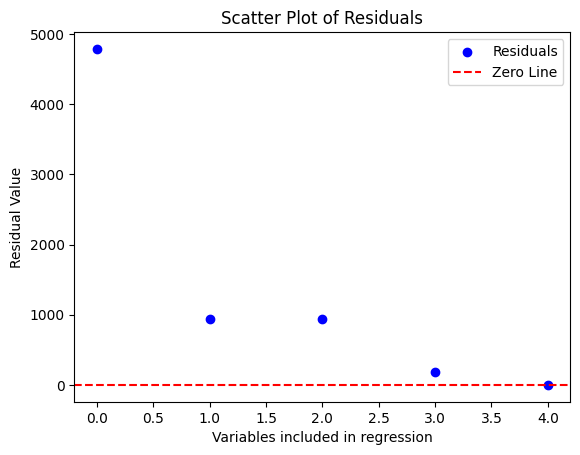

In [7]:
import matplotlib.pyplot as plt
plt.scatter(range(p), resids, color='blue', label='Residuals')
plt.axhline(0, color='red', linestyle='--', label='Zero Line')
plt.xlabel('Variables included in regression')
plt.ylabel('Residual Value')
plt.title('Scatter Plot of Residuals')
plt.legend()
plt.show()

So it seems adding the 2nd and 4th variable improved model fit significantly (by reducing sum-of-squared residual). How do we statistically determine whether they are redundant? We can test the hypothesis $H_k = 0$ using an F-test:

In [12]:
# test whether kth variable is significant
for k in range(p):
    f_stat, pval = ols.f_test(k)
    print(f"Variable {k} has p-value {pval}")

Variable 0 has p-value 0.8129989461707008
Variable 1 has p-value 3.209628882323652e-31
Variable 2 has p-value 0.00937511174625582
Variable 3 has p-value 6.452513415087515e-29
Variable 4 has p-value 4.743393955410443e-25


So the 2nd, 4th, and 5th variable is significant. We can compare this against the true beta coefficient:

In [13]:
beta

array([ 0.        ,  1.72690962,  0.        ,  1.43543728, -0.64106051])

So in this simple example, stepwise regression using F-test worked in identifying the correct model.